In [113]:
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd

In [114]:
import pandas as pd
import os
from pathlib import Path

def load_all_csvs_with_filename_column(directory):
    """
    Betölti a megadott könyvtár összes .csv fájlját egy közös DataFrame-be,
    és hozzáadja a fájlnevet egy 'filename' oszlopban.

    Args:
        directory (str or Path): A könyvtár elérési útja.

    Returns:
        pd.DataFrame: Az egyesített adatkeret.
    """
    all_dfs = []
    directory = Path(directory)

    for csv_file in directory.glob("*.csv"):
        df = pd.read_csv(csv_file)
        df['filename'] = csv_file.name
        all_dfs.append(df)

    if all_dfs:
        combined_df = pd.concat(all_dfs, ignore_index=True)
    else:
        combined_df = pd.DataFrame()

    return combined_df

# Példa használat
# Cseréld ki e

os.remove('res/merged.csv')
results = load_all_csvs_with_filename_column('res')
results.to_csv('res/merged.csv')


In [115]:
em_true_counts = (
    results.groupby(['qid', 'question', 'derivation'])['em']
    .apply(lambda x: (x == True).sum())
    .reset_index(name='em_true_count')
)

em_true_counts['em_true_count'].max()

10

In [116]:
import re

def replace_numbers(texts, replacement="#"):
    """
    Lecseréli a számokat a megadott helyettesítő karakterláncra,
    eltávolítja a szóközöket, a '$' karaktereket, és a felesleges zárójeleket.

    Args:
        texts (list of str): Kifejezések listája.
        replacement (str): A csereérték (pl. "#" vagy "NUM").

    Returns:
        list of str: A módosított kifejezések listája.
    """
    number_pattern = r"\d+(?:[\.,]\d+)*"

    def clean(text):
        # Számok cseréje
        text = re.sub(number_pattern, replacement, text)
        # Szóközök és $ eltávolítása
        text = text.replace(" ", "").replace("$", "")
        # Felesleges zárójelek eltávolítása
        if text.startswith("(") and text.endswith(")") and text.count('(') == 1 and text.count(')') == 1 :
            text = text[1:-1]
        return text.strip()

    return [clean(text) for text in texts]


derivates = list(em_true_counts['derivation'])
derivates = replace_numbers(derivates)
derivates[1:10], em_true_counts[1:10]['derivation']


(['#-#', '#-#', '#-#', '(#+#)/#', '#-#', '#-#', '(#-#)/#', '#-#', '(#-#)/#'],
 1                        19 - 26
 2                (38,476-24,264)
 3                320,872-690,791
 4    (18,649,161+15,400,475) / 2
 5                     697 - 381 
 6                    1,396-1,292
 7         ($3,366-$4,203)/$4,203
 8                        830-261
 9           (1,298-1,601)/1,601 
 Name: derivation, dtype: object)

In [117]:

#devdf = pd.read_json('dataset_raw/tatqa_dataset_dev.json')
#res = pd.read_csv('res/merged.csv')



results['der_scheme'] = replace_numbers(results['derivation'])

results['em_true_count'] = (
    results.groupby(['qid', 'question'])['em']
    .transform(lambda x: (x == True).sum())
)

results['em_success_rate'] = (
    results.groupby(['qid', 'question'])['em']
    .transform(lambda x: (x == True).sum() / len(x))
)

results['vm_true_count'] = (
    results.groupby(['qid', 'question'])['good']
    .transform(lambda x: (x == True).sum())
)

results['vm_success_rate'] = (
    results.groupby(['qid', 'question'])['good']
    .transform(lambda x: (x == True).sum() / len(x))
)


results.to_csv('res/merged.csv')

# Elemzés

In [118]:
# 1. Csak a hibákat tartalmazó sorok
errors_df = results[results['em'] == False]

# 2. Pivot: kérdésenként megjelölve, mely modell hibázott
error_matrix = (
    errors_df
    .pivot_table(index=['qid', 'question'], columns='filename', values='em', aggfunc=lambda x: 1)
    .fillna(0)
    .astype(int)
)


In [119]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# (opcionális) optimális klaszterszám keresése
scores = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(error_matrix)
    score = silhouette_score(error_matrix, labels)
    scores.append((k, score))
best_k = max(scores, key=lambda x: x[1])[0]

# Clustering futtatása
kmeans = KMeans(n_clusters=best_k, random_state=42)
error_matrix['error_cluster'] = kmeans.fit_predict(error_matrix)


/home/apandy/environemnts/tabular/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/apandy/environemnts/tabular/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/apandy/environemnts/tabular/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/apandy/environemnts/tabular/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The defa

In [120]:
results

,Unnamed: 0,qid,question,derivation,pred,pred_scale,answer,scale,abs,inv,good,parenth,em,filename,der_scheme,em_true_count,em_success_rate,vm_true_count,vm_success_rate
0,0,b2786c1a-37de-4120-b03c-32bf5c81f157,What was the change in the amount for Applianc...,680-774,-94.0,million,-94.00,million,False,False,True,False,True,Ollama_20_gwen3_4b_code_values_v11_m1.csv,#-#,5,0.277778,7,0.388889
1,1,fe11f001-3bfe-4089-8108-412676f0a780,What was the percentage change in the amount f...,(680-774)/774,-12.14,percent,-12.14,percent,False,False,True,False,True,Ollama_20_gwen3_4b_code_values_v11_m1.csv,(#-#)/#,4,0.235294,5,0.294118
2,2,5103aed0-b4e8-4fae-bf78-e2c9f4ba84cf,What is the difference between the domestic an...,4.00 - 1.90,2.1,percent,2.10,percent,False,False,True,False,True,Ollama_20_gwen3_4b_code_values_v11_m1.csv,#-#,4,0.222222,4,0.222222
3,3,4dc8be43-d8d9-4b08-9ffd-9c19012361ce,What is the year on year percentage change in ...,(4.00 - 3.75)/3.75,6.67,percent,6.67,percent,False,False,True,False,True,Ollama_20_gwen3_4b_code_values_v11_m1.csv,(#-#)/#,6,0.333333,5,0.277778
4,4,6c44a1a8-0785-43a0-90ab-7e21df2c57d9,What is the year on year percentage change in ...,(3.40 - 3.70)/3.70,-8.11,percent,-8.11,percent,False,False,True,False,True,Ollama_20_gwen3_4b_code_values_v11_m1.csv,(#-#)/#,3,0.166667,3,0.166667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8745,492,c8ed0bf6-60c5-41e2-97e3-5ece54a1349b,What is the change in total personnel expenses...,"227,727 - 188,503",227727.0,NaN,39224.00,NaN,False,False,False,False,False,Ollama_26_gwen3_4b_nothink_naive_p1.csv,#-#,8,0.444444,8,0.444444
8746,493,4cdc8b2e-e3ea-4c36-bbda-7c409a84cc78,What is the percentage change in total personn...,"(227,727 - 188,503 )/188,503",2.22,percent,20.81,percent,False,False,False,False,False,Ollama_26_gwen3_4b_nothink_naive_p1.csv,(#-#)/#,3,0.176471,5,0.294118
8747,494,ec696158-f93d-4608-903d-a6b9c4e7bfd5,What is the increase / (decrease) in the telec...,86.8 - 87.0,-0.23,million,-0.20,million,False,False,False,False,False,Ollama_26_gwen3_4b_nothink_naive_p1.csv,#-#,4,0.222222,8,0.444444
8748,495,27911d6f-dfe5-487b-bc56-7e5cf16a32e0,What is the average telecommunications install...,(33.2 + 41.5) / 2,33.2,thousand,37.35,million,False,False,False,False,False,Ollama_26_gwen3_4b_nothink_naive_p1.csv,(#+#)/#,6,0.352941,7,0.411765


In [121]:
# Átlagos hiba arány klaszterenként (hány modell rontotta el átlagosan)
error_matrix['error_sum'] = error_matrix.drop(columns='error_cluster').sum(axis=1)

cluster_stats = (
    error_matrix.groupby('error_cluster')['error_sum']
    .agg(['mean', 'count'])
    .sort_values('mean', ascending=False)
)

print(cluster_stats)


                    mean  count
error_cluster                  
6              17.007576    132
0              15.909091     44
7              15.596491     57
1              14.290323     31
2              14.269231     52
3              13.854167     48
4              13.101695     59
5              12.419355     31
8              11.186047     43


In [122]:
pattern_success = (
    results.groupby('der_scheme')['em']
    .agg(em_success_rate='mean', count='count')
    .sort_values('em_success_rate')
)
pattern_success

,em_success_rate,count
der_scheme,,
#-(-#),0.000000,36
#*#,0.000000,34
#+#+#+#,0.000000,18
-#/-#-#,0.000000,18
(#*#)+(#*#),0.000000,18
((#-#)+(#-#))/#,0.000000,18
(-#-(-#))/(-#),0.000000,18
[(#+#)/#]-[(#+#)/#],0.028986,69
((#+#)-(#+#))/(#+#),0.055556,18


In [123]:
# Feltételezve, hogy error_matrix tartalmaz 'error_cluster'
# És van egy df, amiben a kérdésekhez ott a calc_pattern

# Hozzárendeled a klasztereket a kérdésekhez
cluster_assignments = error_matrix['error_cluster'].reset_index()
df_with_cluster = results.merge(cluster_assignments, on=['qid', 'question'])

# Összesítés klaszter + műveletminta szerint
pattern_by_cluster = (
    df_with_cluster[df_with_cluster['em'] == False]
    .groupby(['error_cluster', 'der_scheme'])
    .size()
    .unstack(fill_value=0)
)
pattern_by_cluster

der_scheme,#%-#%,#*#,#+#,#+#+#,#+#+#+#,#+#+#+#+#,#+(#)+#,#+(-#)+#,#-#,#-(-#),...,-#-(#),-#-(-#),-#/#-#,-#/-#-#,-(#+#)/#,-(#+#+#)/#,[(#+#)/#]-[(#+#)/#],[(#+#)/#]-[(-#)+(-#)]/#,[(-#)+(-#)]/#,[(-#)-(-#)]/-#
error_cluster,,,,,,,,,,,,,,,,,,,,,
0,0,0,32,15,0,0,0,0,95,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,40,0,0,0,0,0,55,0,...,0,0,13,0,0,0,0,0,0,0
2,43,0,30,0,0,15,0,0,139,0,...,15,0,0,0,28,14,0,14,0,0
3,0,0,0,0,0,0,0,0,191,0,...,0,15,0,0,0,0,0,0,0,13
4,0,0,38,0,0,0,12,0,330,0,...,0,14,0,0,0,0,0,0,0,0
5,0,0,12,0,0,0,0,0,115,0,...,0,0,0,0,0,0,0,0,0,0
6,53,34,134,52,18,0,0,14,458,36,...,0,17,0,18,33,33,51,0,15,0
7,0,0,16,0,0,0,0,0,230,0,...,0,0,0,0,16,0,16,0,0,0
8,11,0,9,0,0,0,0,0,255,0,...,0,0,0,0,0,0,0,0,0,0


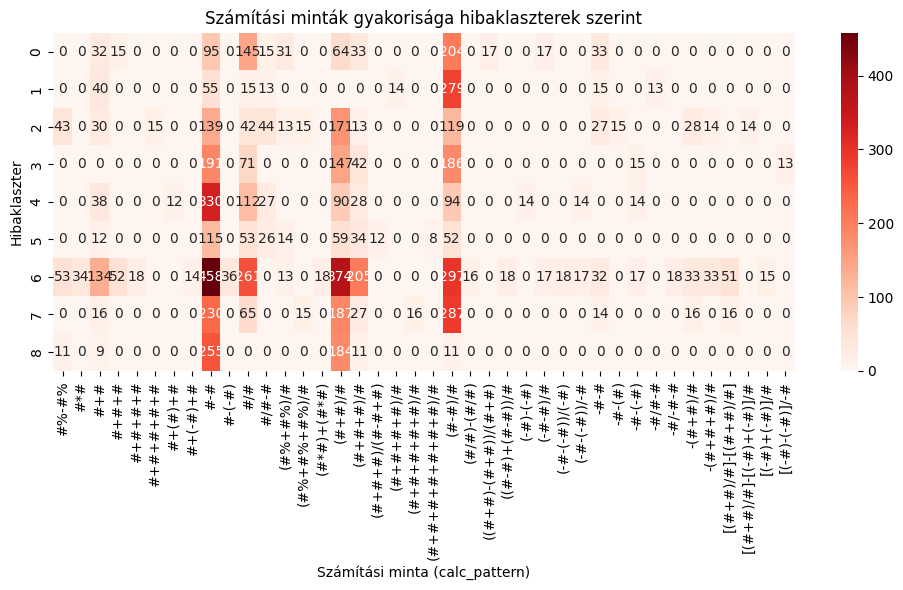

In [124]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.heatmap(pattern_by_cluster, annot=True, fmt='d', cmap='Reds')
plt.title("Számítási minták gyakorisága hibaklaszterek szerint")
plt.xlabel("Számítási minta (calc_pattern)")
plt.ylabel("Hibaklaszter")
plt.tight_layout()
plt.show()


In [125]:
cluster_6_questions = (
    error_matrix[error_matrix['error_cluster'] == 6]
    .reset_index()[['qid', 'question']]
)
print(cluster_6_questions)

filename                                   qid  \
0         010df393-a62e-408d-888a-045a4e435e6a   
1         066fbf2d-e3e7-4f55-bbe0-a71ddeaa2685   
2         073c6499-cf72-47f2-8874-7dfc67f1e251   
3         0a9b94be-b354-46e2-a448-e68b5f9f5e92   
4         0ae9262d-c0fd-4b56-b896-2b37f90810bc   
..                                         ...   
127       f49252e2-158b-4a79-ac56-d21ea67082a8   
128       f91f52fd-ed2d-448f-82ad-c95a10bc64d2   
129       f96cce90-9703-4b6b-9ea4-1a650ac8765a   
130       f9898b19-f84e-4cd8-9cd2-330767f39a38   
131       fd59c14d-0312-4725-92d8-5c30cd5c5c7a   

filename                                           question  
0         What is the difference in amount between Defer...  
1         What is the change in expected rate of salary ...  
2         What is the average of Net cash from operating...  
3         What is the percentage change of net operating...  
4         What was the percentage change in the amount f...  
..                         

In [126]:
# Összes hiba típusként (calc_pattern szerint)
pattern_totals = pattern_by_cluster.sum(axis=0).sort_values(ascending=False)
pattern_totals


der_scheme
#-#                        1868
(#-#)/#                    1529
(#+#)/#                    1276
#/#                         764
(#+#+#)/#                   393
#+#                         311
#/#-#                       125
-#-#                        121
#%-#%                       107
-(#+#)/#                     77
(#%+#%)/#                    71
[(#+#)/#]-[(#+#)/#]          67
#+#+#                        67
-(#+#+#)/#                   47
-#-(-#)                      46
#-(-#)                       36
(-#-#)/#                     34
#*#                          34
(-#-(-#))/-#                 31
(#%+#%+#%)/#                 30
(#*#)+(#*#)                  18
-#/-#-#                      18
#+#+#+#                      18
((#-#)+(#-#))/#              18
(-#-(-#))/(-#)               18
((#+#)-(#+#))/(#+#)          17
(#/#)-(#/#)                  16
(#+#+#+#+#)/#                16
-#-(#)                       15
#+#+#+#+#                    15
[(-#)+(-#)]/#                

In [127]:
cluster_totals = pattern_by_cluster.sum(axis=1).sort_values(ascending=False)
cluster_totals

error_cluster
6    2252
7     889
4     773
2     742
0     701
3     665
8     481
1     444
5     385
dtype: int64

,Unnamed: 0,qid,question,derivation,pred,pred_scale,answer,scale,abs,inv,good,parenth,em,filename,der_scheme,em_true_count,em_success_rate,vm_true_count,vm_success_rate,error_cluster
0,0,b2786c1a-37de-4120-b03c-32bf5c81f157,What was the change in the amount for Applianc...,680-774,-94.0,million,-94.00,million,False,False,True,False,True,Ollama_20_gwen3_4b_code_values_v11_m1.csv,#-#,5,0.277778,7,0.388889,3
1,0,b2786c1a-37de-4120-b03c-32bf5c81f157,What was the change in the amount for Applianc...,680-774,194.0,million,-94.00,million,False,False,False,False,False,Ollama_16_gwen3_4b_naive_p1.csv,#-#,5,0.277778,7,0.388889,3
2,0,b2786c1a-37de-4120-b03c-32bf5c81f157,What was the change in the amount for Applianc...,680-774,NaN,NaN,-94.00,million,False,False,False,False,False,Ollama_7_gemma3_1b_code_values_v11_m1.csv,#-#,5,0.277778,7,0.388889,3
3,0,b2786c1a-37de-4120-b03c-32bf5c81f157,What was the change in the amount for Applianc...,680-774,-94.0,NaN,-94.00,million,False,False,True,False,False,Ollama_19_mistral_code_values_v11_m1.csv,#-#,5,0.277778,7,0.388889,3
4,0,b2786c1a-37de-4120-b03c-32bf5c81f157,What was the change in the amount for Applianc...,680-774,-94.0,million,-94.00,million,False,False,True,False,True,Ollama_2_gemma3n_e4b_code_values_v11_m1.csv,#-#,5,0.277778,7,0.388889,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8745,297,54fec8b2-3105-45fc-aa90-fd07cdd582ae,What is the average age of the executive offic...,(47 + 51 + 64 + 47 + 54 + 41 + 37)/7,38.17,NaN,48.71,NaN,False,False,False,False,False,Ollama_14_mistral_naive_p1.csv,(#+#+#+#+#+#+#)/#,1,0.111111,1,0.111111,5
8746,297,54fec8b2-3105-45fc-aa90-fd07cdd582ae,What is the average age of the executive offic...,(47 + 51 + 64 + 47 + 54 + 41 + 37)/7,47.29,NaN,48.71,NaN,False,False,False,False,False,Ollama_5_gemma3n_e4b_naive_p1.csv,(#+#+#+#+#+#+#)/#,1,0.111111,1,0.111111,5
8747,297,54fec8b2-3105-45fc-aa90-fd07cdd582ae,What is the average age of the executive offic...,(47 + 51 + 64 + 47 + 54 + 41 + 37)/7,47.0,NaN,48.71,NaN,False,False,False,False,False,Ollama_6_gemma3_1b_naive_p1.csv,(#+#+#+#+#+#+#)/#,1,0.111111,1,0.111111,5
8748,297,54fec8b2-3105-45fc-aa90-fd07cdd582ae,What is the average age of the executive offic...,(47 + 51 + 64 + 47 + 54 + 41 + 37)/7,51.0,thousand,48.71,NaN,False,False,False,False,False,Ollama_13_llama3.2_3b_naive_p1.csv,(#+#+#+#+#+#+#)/#,1,0.111111,1,0.111111,5


In [132]:
df_with_cluster.to_csv('res/merged_clusterd.csv')

In [140]:
#param_cols = ['abs','inv','parenth', 'der_scheme']  # vagy amilyen oszlopaid vannak
#param_cols = ['abs','inv']  # vagy amilyen oszlopaid vannak
param_cols = ['parenth', 'der_scheme']
# Csoportosítás paraméterkombinációk szerint
param_perf = (
    results.groupby(param_cols)['em']
    .agg(success_rate='mean', count='count')
    .reset_index()
    .sort_values('success_rate', ascending=False)
)

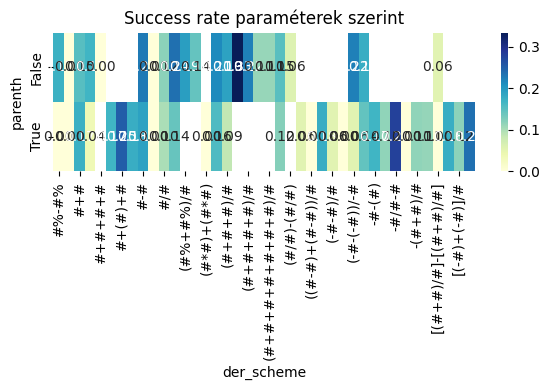

In [142]:
import seaborn as sns
import matplotlib.pyplot as plt

# Pivotálás heatmap-hez
pivot = param_perf.pivot(index='parenth', columns='der_scheme', values='success_rate')

plt.figure(figsize=(6, 4))
sns.heatmap(pivot, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Success rate paraméterek szerint")
plt.ylabel("parenth")
plt.xlabel("der_scheme")
plt.tight_layout()
plt.show()